### Windsat training   
Training notebook with windsat dataset, to experiment with model architecture, sample selection an hyperparameters.

In [88]:
import xbatcher as xb
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from datetime import datetime
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import History

import sys
sys.path.append("../../")

from src.processing import windsat_datacube, create_landmask
from src.model import transform_batch, xy_split, default_model, default_model, plot_history

In [89]:
# default model can be overrrided later.
model = default_model()

def training_step(training_batch: pd.DataFrame, history: History=None ) -> History :
    """ 
    Single training step with a dataframe 2000 samples long. returned expanded history
    """
    X, y = xy_split(training_batch)
    x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 13)
    batch_history = model.fit(x_train, y_train, epochs=1, validation_data=(x_test,y_test))

    # Manage the history of each training run
    if history is None:
        history = batch_history
    else:
        for key in history.history.keys():
            history.history[key].extend(batch_history.history[key])

    return history

In [90]:
#Load the dataset from the folder
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 21, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 121kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 60kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 168B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 348MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 697MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 174MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [91]:
# Preprocess and selec the dataset
landmask = create_landmask(lon=ds.lon.values, lat=ds.lat.values)
ds["landmask"] = (("latitude_grid", "longitude_grid"), landmask.values)

# # NOTE: Select only equatorial latitudes (most likelly without snow coverage)
ascds = ds.sel(swath_sector=0).where(ds.landmask == 0)
variables = ["time","tbtoa", "surtep_ERA5","landmask"]
ascds = ascds[variables]
#TODO: generate the variables in this stage instead on the dataframe step

# ascds.tbtoa.sel(day_number=1, polarization=1, frequency_band=1).plot()
ascds

<xarray.Dataset> Size: 792MB
Dimensions:      (day_number: 21, frequency_band: 2, latitude_grid: 720,
                  longitude_grid: 1440, polarization: 2)
Coordinates:
    lat          (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon          (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number   (day_number) int32 84B 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21
Dimensions without coordinates: frequency_band, latitude_grid, longitude_grid,
                                polarization
Data variables:
    time         (day_number, frequency_band, latitude_grid, longitude_grid) float64 348MB dask.array<chunksize=(1, 1, 240, 480), meta=np.ndarray>
    tbtoa        (day_number, polarization, frequency_band, latitude_grid, longitude_grid) float32 348MB dask.array<chunksize=(1, 1, 1, 240, 480), meta=np.ndarray>
    surtep_ERA5  (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    landmask     (latitude_grid, longitude_grid) float64 8MB 0.0 0.0 ... nan nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [148]:
ascds["tbtoa_18Ghz_V"] = ascds.tbtoa.sel(polarization=0,frequency_band=0)
ascds

<xarray.Dataset> Size: 879MB
Dimensions:        (day_number: 21, frequency_band: 2, latitude_grid: 720,
                    longitude_grid: 1440, polarization: 2)
Coordinates:
    lat            (latitude_grid) float32 3kB -89.88 -89.62 ... 89.62 89.88
    lon            (longitude_grid) float32 6kB 180.1 180.4 ... 179.6 179.9
  * day_number     (day_number) int32 84B 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 21
Dimensions without coordinates: frequency_band, latitude_grid, longitude_grid,
                                polarization
Data variables:
    time           (day_number, frequency_band, latitude_grid, longitude_grid) float64 348MB dask.array<chunksize=(1, 1, 240, 480), meta=np.ndarray>
    tbtoa          (day_number, polarization, frequency_band, latitude_grid, longitude_grid) float32 348MB dask.array<chunksize=(1, 1, 1, 240, 480), meta=np.ndarray>
    surtep_ERA5    (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    landmask       (latitude_grid, longitude_grid) float64 8MB 0.0 0.0 ... nan
    tbtoa_18Ghz_V  (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [128]:
# Xbatcher generator:
bgen = xb.BatchGenerator(
    ds=ascds,
    input_dims ={"day_number":10, "latitude_grid":144,"longitude_grid":72},
    )
print(len(bgen))
batch_example = bgen[0]
batch_example

200


<xarray.Dataset> Size: 5MB
Dimensions:         (day_number: 10, latitude_grid: 144, longitude_grid: 72,
                     sample: 4)
Coordinates:
    lat             (latitude_grid) float32 576B -89.88 -89.62 ... -54.38 -54.12
    lon             (longitude_grid) float32 288B 180.1 180.4 ... 197.6 197.9
  * day_number      (day_number) int32 40B 1 2 3 4 5 6 7 8 9 10
  * sample          (sample) object 32B MultiIndex
  * frequency_band  (sample) int64 32B 0 0 1 1
  * polarization    (sample) int64 32B 0 1 0 1
Dimensions without coordinates: latitude_grid, longitude_grid
Data variables:
    time            (sample, day_number, latitude_grid, longitude_grid) float64 3MB ...
    tbtoa           (sample, day_number, latitude_grid, longitude_grid) float32 2MB ...
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 415kB ...
    landmask        (latitude_grid, longitude_grid) float64 83kB 0.0 0.0 ... nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [129]:
# We will convert the batches into dataframes for training with this custom function
batch_df = batch_example.to_dataframe()
batch_df = transform_batch(batch_df)
batch_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
3,1,264.402344,0.106698,-0.269340,211.845001,166.422501,220.574997,190.177505,0.396635,0.395874
4,1,264.404816,0.106698,-0.273540,211.337494,166.422501,220.574997,190.177505,0.396669,0.395874
5,1,264.404816,0.106698,-0.273540,211.337494,165.837494,220.574997,190.177505,0.396669,0.395874
6,1,264.404816,0.106698,-0.273540,211.337494,165.837494,220.227493,190.177505,0.396669,0.395901
7,1,264.404816,0.106698,-0.273540,211.337494,165.837494,220.227493,189.797501,0.396669,0.395901
...,...,...,...,...,...,...,...,...,...,...
1679,6,266.100586,0.192950,-0.302786,224.804993,175.630005,222.302490,189.269989,0.358333,0.357566
1680,6,266.109009,0.192950,-0.306941,223.512497,175.630005,222.302490,189.269989,0.358388,0.357566
1681,6,266.109009,0.192950,-0.306941,223.512497,174.679993,222.302490,189.269989,0.358388,0.357566
1682,6,266.109009,0.192950,-0.306941,223.512497,174.679993,221.324997,189.269989,0.358388,0.357614


In [126]:
#OPTIONAL: define a custom model to train:
n_vars = batch_df.shape[1] - 1 # dont count the prediction column.

model = Sequential([
    Input((n_vars,)),
    BatchNormalization(),
    Dense(30,activation="relu", name = "hiddenLayer1"),
    Dense(20,activation="relu", name = "hiddenLayer2"),
    Dense(10,activation="relu", name = "hiddenLayer3"),
    Dense(1,activation="relu", name = "outputLayer")
])

model.compile(
    optimizer = "adam",
    loss ="mse",
    metrics = ["mse"]
)
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,177 (4.60 KB)

 Trainable params: 1,159 (4.53 KB)

 Non-trainable params: 18 (72.00 B)

In [130]:
# Leftovers training loop
history = None
min_samples = 64000 # model batch training is 32 by default, so this makes nice numbers appear.
leftovers = pd.DataFrame()

# TODO: make this sequential process into a parallel one (retrieve data - train model)
for i, batch in enumerate(bgen):
    batch = batch.to_dataframe()
    batch = transform_batch(batch)

    batch = pd.concat([leftovers,batch])
    print(f"Standard Batch {i+1} out of {len(bgen)} - {100*(i+1)/len(bgen):.2f}%")
    # Shuffle the dataset
    # batch = batch.sample(frac=1).reset_index(drop=True)

    if batch.shape[0] < min_samples:
        leftovers = pd.concat([leftovers,batch])
        continue

    training_batch, leftovers = batch[:min_samples], batch[min_samples:]

    history = training_step(training_batch, history)

    while leftovers.shape[0] > min_samples:
        training_batch, new_leftovers = leftovers[:min_samples], leftovers[min_samples:]
        history = training_step(training_batch, history)
        leftovers = new_leftovers

    print(f"Standard Batch {i+1} out of {len(bgen)} - {100*(i+1)/len(bgen):.2f}%")
    # print(f"Cos(lat) = [{batch['lat'].min():.4f},{batch['lat'].max():.4f}]")
    # print(f"Sin(Lon) = [{batch['lon'].min():.4f},{batch['lon'].max():.4f}]")

1800/1800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 632.5605 - mse: 632.5605 - val_loss: 37.1047 - val_mse: 37.1047
Standard Batch 3 out of 200 - 1.50%
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 29.7343 - mse: 29.7343 - val_loss: 15.1731 - val_mse: 15.1731
Standard Batch 4 out of 200 - 2.00%
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 23.2526 - mse: 23.2526 - val_loss: 18.5937 - val_mse: 18.5937
Standard Batch 5 out of 200 - 2.50%
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.1142 - mse: 9.1142 - val_loss: 5.1157 - val_mse: 5.1157
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10.0908 - mse: 10.0908 - val_loss: 7.1346 - val_mse: 7.1346
Standard Batch 6 out of 200 - 3.00%
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 12.0346 - mse: 12.0346 - val_loss: 8.7364 - val_mse: 8.7364
Standard Batch 7 out of 200 - 3.50%
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 13.1572 - mse: 13.1572 - val_loss: 8.4195 - val_mse: 8.4195
Standard Batch 8 out of 200 - 4.00%
1

In [131]:
# Save FINAL model weights and history data.
now = datetime.now().strftime(r"%Y_%m_%dT%H%M%S")

weights_path = f"../../models/{now}.weights.h5"
model.save_weights(weights_path)

history_path = f"../../models/{now}_history.json"
with open(history_path, "wb") as file:
    pickle.dump(history, file)

(<Figure size 2400x1000 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='mse [K]'>,
        <Axes: xlabel='Epoch', ylabel='log_10(mse [K])'>], dtype=object))

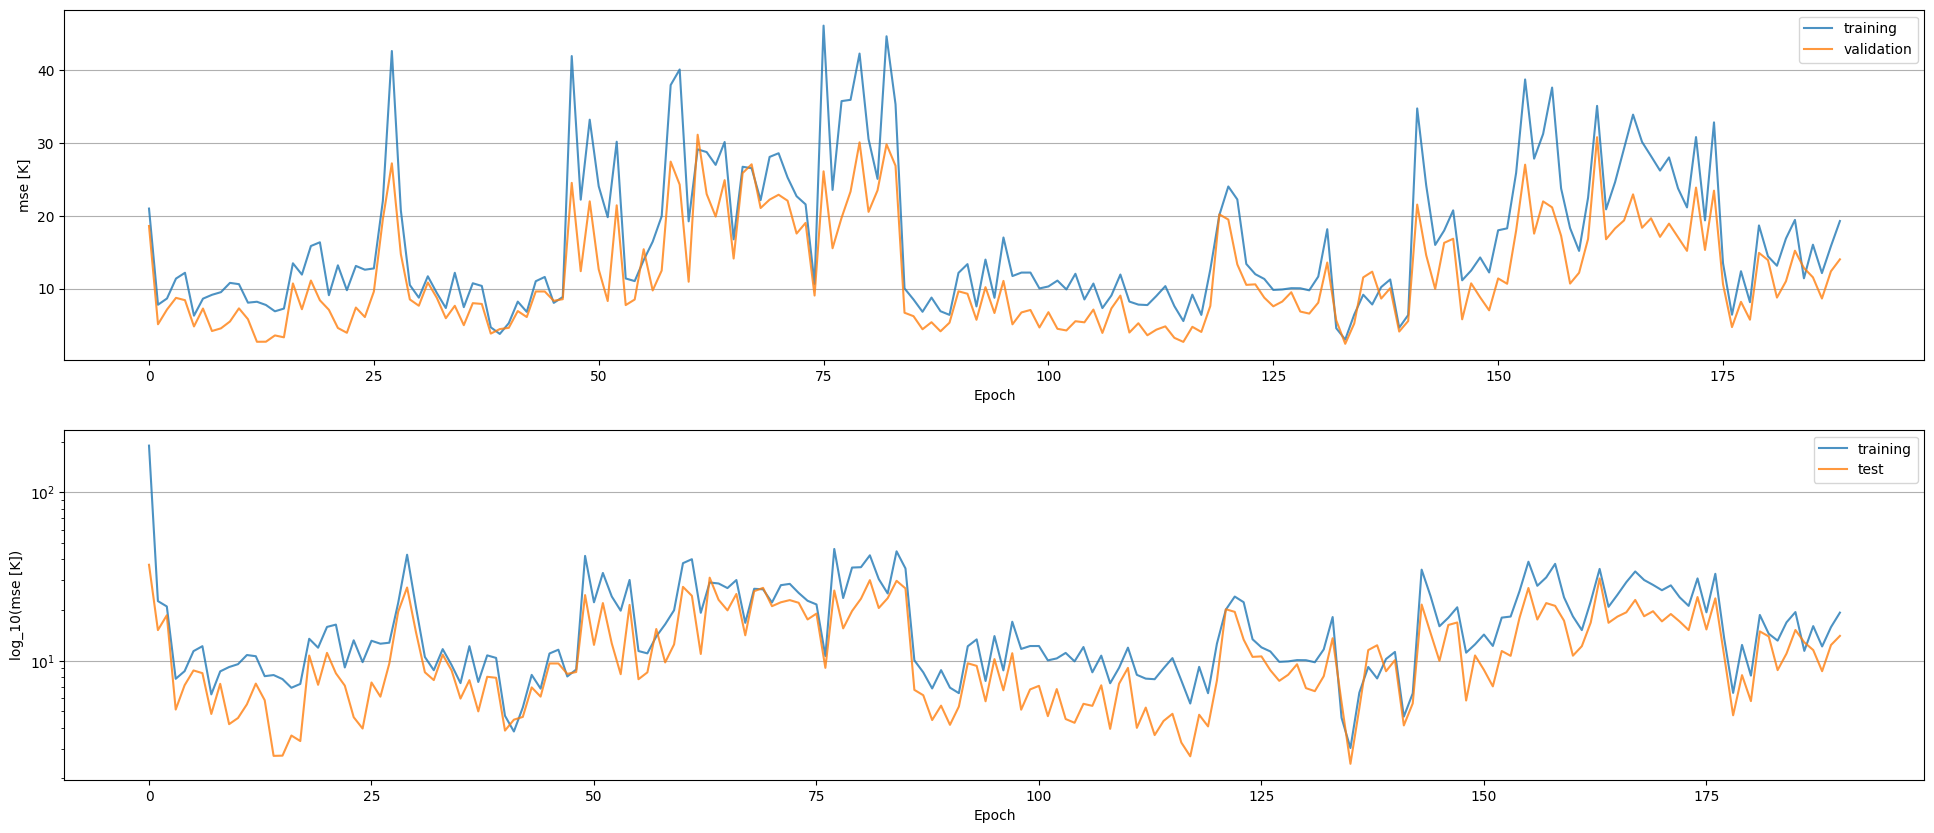

In [132]:
plot_history(history)

---

Some test on the results

In [66]:
ascds.sel(day_number=10)

<xarray.Dataset> Size: 46MB
Dimensions:      (frequency_band: 2, latitude_grid: 720, longitude_grid: 1440,
                  polarization: 2)
Coordinates:
    lat          (latitude_grid) float32 3kB -89.88 -89.62 ... 89.62 89.88
    lon          (longitude_grid) float32 6kB 180.1 180.4 180.6 ... 179.6 179.9
    day_number   int32 4B 10
Dimensions without coordinates: frequency_band, latitude_grid, longitude_grid,
                                polarization
Data variables:
    time         (frequency_band, latitude_grid, longitude_grid) float64 17MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa        (polarization, frequency_band, latitude_grid, longitude_grid) float32 17MB dask.array<chunksize=(1, 1, 240, 480), meta=np.ndarray>
    surtep_ERA5  (latitude_grid, longitude_grid) float32 4MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    landmask     (latitude_grid, longitude_grid) float64 8MB 0.0 0.0 ... nan nan
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [133]:
# Predict the values for a single day:
sample = bgen[-1]

sample_df = sample.to_dataframe()
sample_df = transform_batch(sample_df)
sample_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz
3,12,275.096313,0.578925,0.210045,190.942505,120.527496,214.487503,159.755005,0.999898,0.999887
4,12,272.863983,0.575362,0.235566,208.772491,120.527496,214.487503,159.755005,0.999887,0.999887
5,12,272.863983,0.575362,0.235566,208.772491,152.647491,214.487503,159.755005,0.999887,0.999887
6,12,272.863983,0.575362,0.235566,208.772491,152.647491,222.492493,159.755005,0.999887,0.999876
7,12,272.863983,0.575362,0.235566,208.772491,152.647491,222.492493,179.345001,0.999887,0.999876
...,...,...,...,...,...,...,...,...,...,...
57083,20,246.871628,0.344069,0.067580,249.304993,226.282501,238.985001,221.089996,0.986134,0.986265
57084,20,243.137207,0.319373,0.002182,244.512497,226.282501,238.985001,221.089996,0.823012,0.986265
57085,20,243.137207,0.319373,0.002182,244.512497,220.732498,238.985001,221.089996,0.823012,0.986265
57086,20,243.137207,0.319373,0.002182,244.512497,220.732498,231.922485,221.089996,0.823012,0.823456


In [134]:
X, _ = xy_split(sample_df)
y_pred =  model.predict(X)
sample_df["surtep_PRED"] = y_pred
sample_df["diff"] = sample_df["surtep_PRED"] - sample_df["surtep_ERA5"]
sample_df

1784/1784 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step


,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,surtep_PRED,diff
3,12,275.096313,0.578925,0.210045,190.942505,120.527496,214.487503,159.755005,0.999898,0.999887,293.449890,18.353577
4,12,272.863983,0.575362,0.235566,208.772491,120.527496,214.487503,159.755005,0.999887,0.999887,286.761230,13.897247
5,12,272.863983,0.575362,0.235566,208.772491,152.647491,214.487503,159.755005,0.999887,0.999887,280.372253,7.508270
6,12,272.863983,0.575362,0.235566,208.772491,152.647491,222.492493,159.755005,0.999887,0.999876,281.722717,8.858734
7,12,272.863983,0.575362,0.235566,208.772491,152.647491,222.492493,179.345001,0.999887,0.999876,283.113922,10.249939
...,...,...,...,...,...,...,...,...,...,...,...,...
57083,20,246.871628,0.344069,0.067580,249.304993,226.282501,238.985001,221.089996,0.986134,0.986265,246.892807,0.021179
57084,20,243.137207,0.319373,0.002182,244.512497,226.282501,238.985001,221.089996,0.823012,0.986265,243.796371,0.659164
57085,20,243.137207,0.319373,0.002182,244.512497,220.732498,238.985001,221.089996,0.823012,0.986265,244.825439,1.688232
57086,20,243.137207,0.319373,0.002182,244.512497,220.732498,231.922485,221.089996,0.823012,0.823456,245.381607,2.244400


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


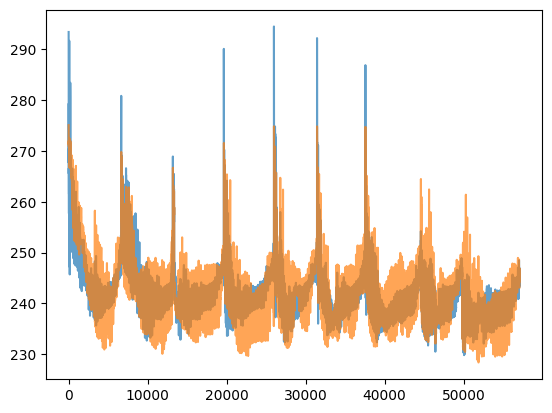

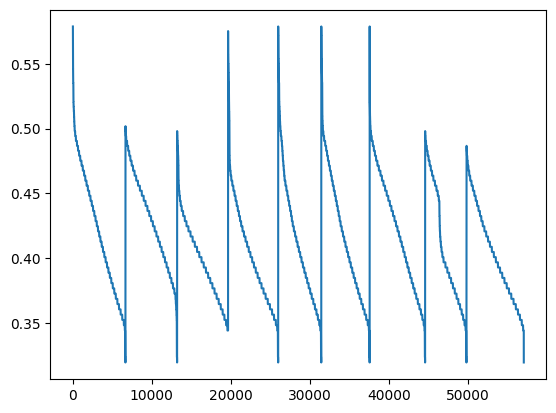

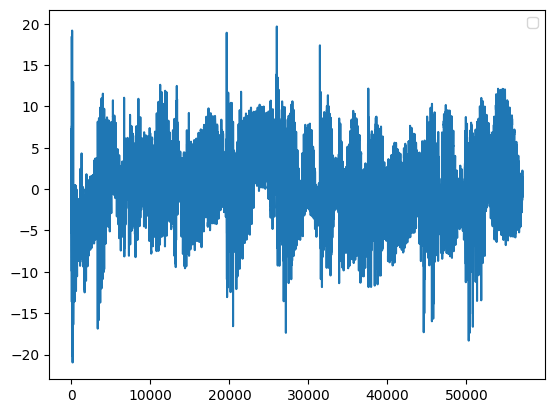

In [146]:
# difference = sample_df["diff"].values.reshape((72,144))
# plt.imshow(difference)
plot_df = sample_df[:] 
plt.plot(plot_df["surtep_PRED"],alpha=.7,label="prediction")
plt.plot(plot_df["surtep_ERA5"],alpha=0.7, label = "ERA5")
plt.figure()
plt.plot(plot_df["lat"])
plt.figure()
plt.plot(plot_df["diff"])
plt.legend()

Not the case, the model trained in this manner does not work at all

The lat-lon slicing creates uniform squares, so the model loss is low in some quadrants and high in others:

NEXT STEP:
    I believe that snow covered areas are causing a problem. 

    a) record the loss function for each batch and then plot it on a map

    b) selec only equatorial latitudes (-45,45) to see if results improve

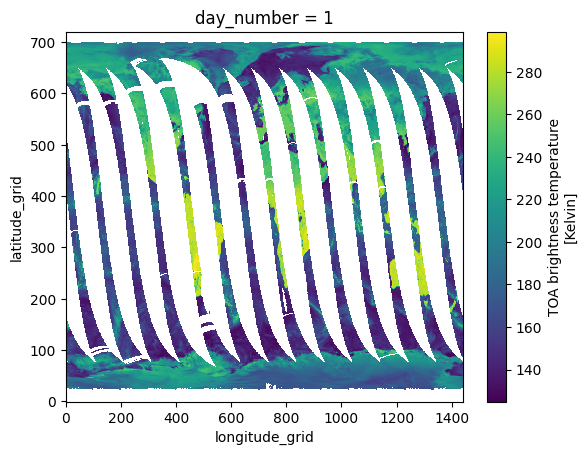

In [19]:
ds.tbtoa.sel(day_number=1, polarization=1, frequency_band=1, swath_sector=0).plot()

# I AM NOT FILTERING THE OCEAN!